In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
from brokenaxes import brokenaxes
from matplotlib import pyplot as plt

In [2]:
# Make a color palette for the swarmplot that colors replicates differently.
greys = sns.color_palette('Greys', n_colors=8)
greens = sns.color_palette('Greens', n_colors=8)
purples = sns.color_palette('Purples', n_colors=8)
reddish_purple = sns.set_hls_values(sns.xkcd_rgb['reddish purple'], 0.9, 0.3, 1)

In [3]:
# Continuous data from photobioreactor (no lights) from 08/31/19.
# Growth curves are smoother but slower than continuous data from Spark.
# Note: first 19 rows are metadata for the experiment.
bioreactor_continuous_df = pd.read_csv('data/fig3/083119_CCMB1_bioreactor_continuous.csv', skiprows=19)
# Column names have whitespace off the machine
bioreactor_continuous_df.columns = [x.strip() for x in bioreactor_continuous_df.columns]

# Endpoint data from 08/31/19 spark experiment. Produced from continuous data, endpoint is 80h. 
# TODO: supplementary spark curves? 
spark_endpoint_df = pd.read_csv('data/fig3/083119_CCMB1_ambient_OD80hrs_spark_blanked.csv', index_col=0, skipinitialspace=True)


# Endpoint data (~4 days) from matched 3mL cultures in 10% CO2 and ambient. 
# Matched cultures in 10% and ambient CO2. 
matched_od_df = pd.read_csv('data/fig3/090619_CCMB1_mutants_endpointODs_tubes.csv')
amb_df = matched_od_df[matched_od_df.condition == 'amb']
highCO2_df = matched_od_df[matched_od_df.condition == '10% CO2']

In [4]:
bioreactor_mapping = {'recon.1': 'od-sensors-1.od-680 ',
                      'recon.2': 'od-sensors-2.od-680 ',
                      'recon.4': 'od-sensors-3.od-680 ',
                      'K194M.3': 'od-sensors-4.od-680 ',
                      'K194M.4': 'od-sensors-5.od-680 ',
                      'lsPrk.3': 'od-sensors-6.od-680 ',
                      'lsPrk.4': 'od-sensors-7.od-680 ',
                      'pos': 'od-sensors-8.od-680 ',
                     }
bioreactor_names2plot = {'recon.4': purples[-2],
                         'lsPrk.3': greens[-2]}

In [5]:
# Groupings of samples for plotting spark endpoint data
all_names = spark_endpoint_df.replicate.unique()
exp = [c for c in all_names if c.startswith('rec')]
neg = [c for c in all_names if c.startswith('K194')]
neg_exp = [c for c in all_names if c.startswith('ls')]

# Colors to use for the spark endpoint data
replicates_palette = {}
replicates_palette.update([(n, greys[-2*i-1]) for i, n in enumerate(neg)])
replicates_palette.update([(n, greens[-2*i-1]) for i, n in enumerate(neg_exp)])
replicates_palette.update([(n, purples[-2*i-1]) for i, n in enumerate(exp)])

In [6]:
# Calculate mean values for the 3mL scale experiment. 
mean_10pct = highCO2_df.groupby('strain_name').mean()
mean_amb = amb_df.groupby('strain_name').mean()

std_10pct = highCO2_df.groupby('strain_name').std()
std_amb = amb_df.groupby('strain_name').std()

NameError: name 'ax0b' is not defined

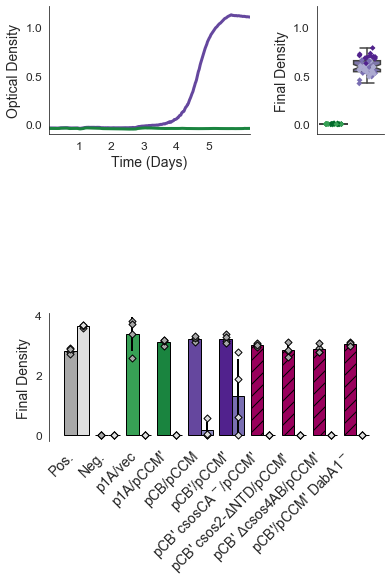

In [7]:
plt.figure(figsize=(6,8))
sns.set_style('white')

gs = plt.GridSpec(3, 2, width_ratios=[9, 3], height_ratios=[1, 1, 1])

ax0 = plt.subplot(gs[0, 0])

for name, color in bioreactor_names2plot.items():
    # 'key' is the name of the measurement/well we are looking at. 
    key = bioreactor_mapping[name]
    my_tube = bioreactor_continuous_df[bioreactor_continuous_df['key'] == key]
    
    times = my_tube.time.values
    ods = pd.Series(my_tube.value.values)
    median_filtered_ods = ods.rolling(5).median()
    smoothed_ods = median_filtered_ods.rolling(10).mean()
    plt.plot(times, smoothed_ods, lw=3, color=color)
    
plt.xticks(np.arange(0, 144, 24), np.arange(0, 144, 24)//24, fontsize=12)
plt.yticks(np.arange(0.0, 1.01, 0.5), fontsize=12)

plt.xlim(2, 150)
plt.ylim(-0.1, 1.21)

plt.xlabel('Time (Days)', fontsize=14)
plt.ylabel('Optical Density', fontsize=14)


sns.despine(right=True, top=True, ax=ax0)

ax1 = plt.subplot(gs[0, 1])

sns.boxplot(data=spark_endpoint_df, x='sample', y='OD', order=('Rub. alone', 'Full CCM'),
            whis=np.inf, palette={'Full CCM': purples[-3], 'Rub. alone': greens[-3]}, notch=True)
sns.stripplot(data=spark_endpoint_df, x='sample', y='OD', order=('Rub. alone', 'Full CCM'),
              palette=replicates_palette, size=4, hue='replicate', jitter=0.25, marker='D', edgecolor='black')


plt.legend().set_visible(False)

plt.ylim(-0.1, 1.21)
plt.xticks([], fontsize=14)
plt.yticks(np.arange(0.0, 1.01, 0.5), fontsize=12)
plt.xlabel('')
plt.ylabel('Final Density', fontsize=14)
sns.despine(ax=ax1)

ax2 = plt.subplot(gs[2, :])

custom_pal = {'10% CO2': greys[3], 'amb': greys[1]}

order = ['CAfree+EGFP/HCAII', 'lsK194M/AGFP', 'ls/AGFP', 'LS/13.6 HnCcm11', 'gg9/HnCcm11', '13.6 recons',
 '13.6 C173s/Ccm11', '13.6 dS2/Ccm11', '13.6 d4AB/Ccm11', '13.6 Cb11/ dDab1', ]
ticknames = ['Pos.', "Neg.", 'p1A/vec', "p1A/pCCM'", 'pCB/pCCM', "pCB'/pCCM'",
 "pCB' csosCA$^-$/pCCM'", "pCB' csos2-$\Delta$NTD/pCCM'", "pCB' $\Delta$csos4AB/pCCM'",
 "pCB'/pCCM' DabA1$^-$", ]

bars_10pct = [
    greys[3], greys[3], # controls - grey
    # Rubisco alone/no carboxysome - green
    greens[-3], greens[-2], 
    # Full CCM gene set
    purples[-2], purples[-1],
    # Mutants with most of the CCM are red/purple
    reddish_purple, reddish_purple, reddish_purple, reddish_purple]

bars_amb = [
    greys[1], greys[1],
    greens[-5], greens[-4],
    purples[-4], purples[-3],
    reddish_purple, reddish_purple, reddish_purple, reddish_purple]

xs = np.arange(len(order))

width = 0.4
offset = width/2
bars_10pct = plt.bar(xs-offset, mean_10pct.loc[order].OD.values, color=bars_10pct, width=width, edgecolor='k')
plt.bar(xs+offset, mean_amb.loc[order].OD.values, color=bars_amb, width=width, edgecolor='k')

for bar in bars_10pct[-4:]:
    bar.set_hatch('//')

for i, name in enumerate(order):
    my_xs = np.ones(4)*i
    plt.scatter(my_xs-offset, highCO2_df[highCO2_df.strain_name == name].OD.values,
                marker='D', s=25, color=greys[3], edgecolors='k', zorder=10)
    plt.scatter(my_xs+offset, amb_df[amb_df.strain_name == name].OD.values,
                marker='D', s=25, color=greys[1], edgecolors='k', zorder=10)

# TODO: prefer 95% CI to std deviation
plt.errorbar(xs-0.2, mean_10pct.loc[order].OD.values, yerr=std_10pct.loc[order].OD.values, color='k', ls='', elinewidth=2)
plt.errorbar(xs+0.2, mean_amb.loc[order].OD.values, yerr=std_amb.loc[order].OD.values, color='k', ls='', elinewidth=2)

plt.xticks(np.arange(len(ticknames)), ticknames, rotation=45, fontsize=14, ha='right')
plt.yticks(np.arange(0, 4.1, 2.0), fontsize=12)
plt.xlabel('')
plt.ylabel('Final Density', fontsize=14)
plt.ylim(-0.2, 4.05)
sns.despine(bottom=True, ax=ax2)

# Set spacing
plt.subplots_adjust(wspace=0.5)

# Shift the broken axis over a bit
posb = ax0b.get_position()
offset = 0.05
ax0b.set_position([posb.x0 - offset, posb.y0, posb.x1-posb.x0, posb.y1-posb.y0])

plt.savefig('fig3_AmbCurves_wQuant.png', dpi=300)
plt.show()

In [ ]:
key = 'od-sensors-3.od-680 '
my_tube = bioreactor_continuous_df[bioreactor_continuous_df['key'] == key]

times = my_tube.time.values
ods = pd.Series(my_tube.value.values)
median_filtered_ods = ods.rolling(5).median()
smoothed_ods = median_filtered_ods.rolling(10).mean()

mask = np.logical_and(smoothed_ods > 5e-3, smoothed_ods < 0.1)
log_ods = np.log(smoothed_ods[mask])
matching_times = times[mask]

res = stats.linregress(matching_times, log_ods)
pred_log_OD = res.slope*matching_times + res.intercept
pred_OD = np.exp(pred_log_OD)

print('Predicted exponential growth rate', res.slope, '/hr')
dt_hrs = np.log(2)/res.slope
print('Predicted doubling time', dt_hrs, 'hrs')


plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(times, smoothed_ods)
plt.plot(matching_times, pred_OD, ls='--')
plt.xlim(50, 150)
plt.ylim(0.01, 1.5)

plt.show()

In [ ]:
# Started with 0.01 OD units.
OD0 = 0.005
ODF = 0.2
log_OD_ratio = np.log(ODF/OD0)
growth_rate = .21 # /hr
time = log_OD_ratio/growth_rate
print(time, 'hrs')

In [8]:
matched_od_df

,label,condition,measured_OD,dilution_factor,OD,note,strain_name
0,AF-1-1,amb,0.371,5,1.855,NaN,13.6 recons
1,AF-1-2,amb,0.118,5,0.590,NaN,13.6 recons
2,AF-1-3,amb,0.004,1,0.004,NaN,13.6 recons
3,AF-1-4,amb,0.550,5,2.750,NaN,13.6 recons
4,AF-1-5,amb,0.012,1,0.012,NaN,lsK194M/AGFP
5,AF-1-6,amb,0.009,1,0.009,NaN,lsK194M/AGFP
6,AF-1-7,amb,0.007,1,0.007,NaN,lsK194M/AGFP
7,AF-1-8,amb,0.006,1,0.006,NaN,lsK194M/AGFP
8,AF-1-9,amb,0.014,1,0.014,NaN,ls/AGFP
9,AF-1-10,amb,0.006,1,0.006,NaN,ls/AGFP
